In [19]:
import background_generation as backgen
import numpy as np
import pickle
from pathlib import Path
from PIL import Image
import sys
from matplotlib import pyplot as plt

import background_generation as backgen
#windows
sys.path.insert(0, r"C:\Users\adria\Documents\Mestrado\texture_codes\modules")
root_dir = Path(r"C:\Users\adria\Documents\Mestrado\texture_codes\modules")

#linux
#sys.path.insert(0, "/home/adriano/projeto_mestrado/modules/")
#root_dir = f"/home/adriano/projeto_mestrado/modules"

from Utils import functions


def return_background(generate,dir_images,dir_labels,directory_backs,vector_backgrounds,img_back):
    if generate:
        while not img_back in vector_backgrounds:
            if img_back in dir_images and img_back in dir_labels:
                background = backgen.estimate_background(f'{dir_images}/{img_back}', f'{dir_labels}/{img_back}')
            else:
                n_background = np.random.randint(0, len(vector_backgrounds))
                img_back = vector_backgrounds[n_background]
                background = np.array(Image.open(f'{directory_backs}/{vector_backgrounds[n_background]}')) 
    else:
        n_background = np.random.randint(0, len(vector_backgrounds))
        img_back = vector_backgrounds[n_background]
        background = np.array(Image.open(f'{directory_backs}/{img_back}'))
    return background 

def returns_array_pickle(num_maps,array_maps_pickle):
    sorted_array_pickels = []
    for i in range(num_maps):
        n_pickle = np.random.randint(1, len(array_maps_pickle))    
        sorted_array_pickels.append(array_maps_pickle[n_pickle])
    return sorted_array_pickels

def compatible_map_with_backg(sorted_array_pickels, background, dir_maps_pickle):    
    cont = 0
    for i in range(len(sorted_array_pickels)):
        path_map = (f"{dir_maps_pickle}/{sorted_array_pickels[i]}")
        map_pickle = pickle.load(open(path_map, 'rb'))           
        vessel_map = map_pickle['vessel_model'].vessel_map 
        original_map = vessel_map.mapped_values
        vessel_mask = vessel_map.mapped_mask_values
        normalized_original_map = backgen.normalize(background,original_map,vessel_mask,40)            
        if normalized_original_map is not None:
            cont += 1                  
    if cont == len(sorted_array_pickels):
        background_norm = background
        return background_norm
    else:
        return None

def check_compatible(array_pickles,number_images,array_backrounds, directory_backs,dir_maps_pickle,array_images,directory_images,directory_labels):
    count_errors = 0
    vector_dict = []
        
    for i in range(number_images):
        n_random = np.random.randint(0, len(array_backrounds))
        path_img = array_backrounds[n_random]

        if path_img in array_backrounds:
            background = np.array(Image.open(f'{directory_backs}/{path_img}'))
            print("tem path_img")
        else:
            print('não tem path_img')
            background = backgen.estimate_background(f'{directory_images}/{path_img}', f'{directory_labels}/{path_img}')

        back =  compatible_map_with_backg(array_pickles, background, dir_maps_pickle)
        if back is not None:                   
            dict = {
                'name': path_img,
                'back': background,
            }
            vector_dict.append(dict)
            
        else:
            count_errors += 1       
    print(f"incompatible: {count_errors}")
    return vector_dict


#def generate_maps(params):
   
if __name__ == '__main__':

    #Aumentar o limiar para testar se fica compatível no máximo valor
    #Gerar as curvas de bezier dentro do algoritmo - tamanho setado pelo cliente - distancia entre o ponto 1 e ponto 2, numero de pontos, max_vd, 
    params = { 'dir_maps_pickle': f'{root_dir}/Vessel_models_pickle',
                'num_maps': 1, # number of maps to be inserted
                'num_images': 5, #number of images desired
                'dir_backs': f'{root_dir}/Background/Artificially_generated_maps', #background's directory
                'dir_images': f'{root_dir}/Images/vessel_data/images', # original images directory
                'dir_labels': f'{root_dir}/Images/vessel_data/labels_20x', # label directory
                'dir_traces': f'{root_dir}/Artificial_lines/bezier_traces', # directory of traces - Bezier curves
                'generate_back':False, #
                'out_dir': f'{root_dir}/Images/Background_with_vessels_tests', #output directory
                'min_number_vessels': 2, # minimum number of vessels
                'max_number_vessels': 5, # maximum number of vessels
                # Bezier Curves parameters
                'max_vd' : 500,
                'precision': 100,
                'number_cols': 1776,
                'number_rows': 1504,
                'number_points': 25,
            }    
    


    array_maps_pickle = functions.read_directories(params['dir_maps_pickle'])
    array_images = functions.read_directories(params['dir_images'])
    array_labels = functions.read_directories(params['dir_labels'])
    array_backrounds = functions.read_directories(params['dir_backs'])
    array_traces = functions.read_directories(params['dir_traces'])

    number_maps = params['num_maps']
    dir_maps_pickle = params['dir_maps_pickle']
    directory_backs = params['dir_backs']
    directory_images = params['dir_images']
    directory_labels = params['dir_labels']
    directory_traces =  params['dir_traces']
    directory_out = params['out_dir']
    num_images = params['num_images']
    min_number_vessels = params['min_number_vessels']
    max_number_vessels = params['max_number_vessels']    

    array_maps_pickle_sorted = returns_array_pickle(number_maps,array_maps_pickle)    

    #compatible_map_with_backg(array_maps_pickle_sorted, array_backrounds, directory_backs,dir_maps_pickle)

    vector_backgrounds = check_compatible(array_maps_pickle, num_images,array_backrounds,directory_backs,dir_maps_pickle,array_images,directory_images,directory_labels)   

    none_results = 0

    '''for j in range(num_images):
        number_of_vessels = np.random.randint(min_number_vessels, max_number_vessels)        
        
        n_background = np.random.randint(0, len(vector_backgrounds))
        name_background = vector_backgrounds[n_background]
        background = np.array(Image.open(f'{directory_backs}/{name_background}'))          
    
        background_name = name_background.replace("'","").replace(".tiff","")

        clipping_background = background[0:1100,0:1370]
        background_with_pad = np.pad(clipping_background, ((200,200),(200,200)), mode="symmetric", reflect_type="even")
        background_bin = np.zeros(background_with_pad.shape)

        background_with_vessels_bin = background_bin.copy()
        background_with_vessels = background_with_pad.copy()

        has_maps =  np.full(shape = background_with_pad.shape, fill_value=0)
        has_maps_bin =  np.full(shape = background_bin.shape, fill_value=0)

        counter = 0
        while counter < number_of_vessels:
            n_traces = np.random.randint(0, len(array_traces))
            trace = array_traces[n_traces]    
            vector_medial_path = backgen.return_paths(f"{directory_traces}/{trace}")           
            results = backgen.insert_vessels(vector_medial_path[0], vector_medial_path[1], array_maps_pickle_sorted,dir_maps_pickle,background,30)        
            if results is not None:
                vessel_without_artifacts, map_without_artifacts, mask_map, treshold = results  
                background_with_vessels = backgen.insert_map(background_with_vessels,vessel_without_artifacts,map_without_artifacts,mask_map, treshold, has_maps)
                background_with_vessels_bin = backgen.insert_binary_map(background_with_vessels_bin,vessel_without_artifacts,has_maps_bin)
                counter +=1
            else:
                none_results += 1  

        background_clipped = background_with_vessels[200:1304,200:1576]
        background_clipped_bin = background_with_vessels_bin[200:1304,200:1576]    

        img1 = Image.fromarray(background_clipped.astype(np.uint8))
        path = f"{directory_out}/images/{background_name}_{j}_with_{number_of_vessels}.tiff"
        img = img1.save(path)

        img2 = Image.fromarray(background_clipped_bin.astype(np.bool_))
        path = f"{directory_out}/labels/{background_name}_{j}_with_{number_of_vessels}.tiff"
        img = img2.save(path)'''


tem path_img
tem path_img
tem path_img
tem path_img
tem path_img
incompatible: 1


In [30]:
n_background = np.random.randint(0, len(vector_backgrounds))
name_background = vector_backgrounds[n_background]['name']


background =  vector_backgrounds[n_background]['back']
#background = np.array(Image.open(f'{directory_backs}/{name_background}'))          

In [39]:
path_img = 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 2-20X.tiff'
path_img = path_img.replace("'","").replace(".tiff","")
background = backgen.estimate_background(np.array(Image.open(f'{directory_images}/{path_img}.tiff')), np.array(Image.open(f'{directory_labels}/{path_img}.png')))

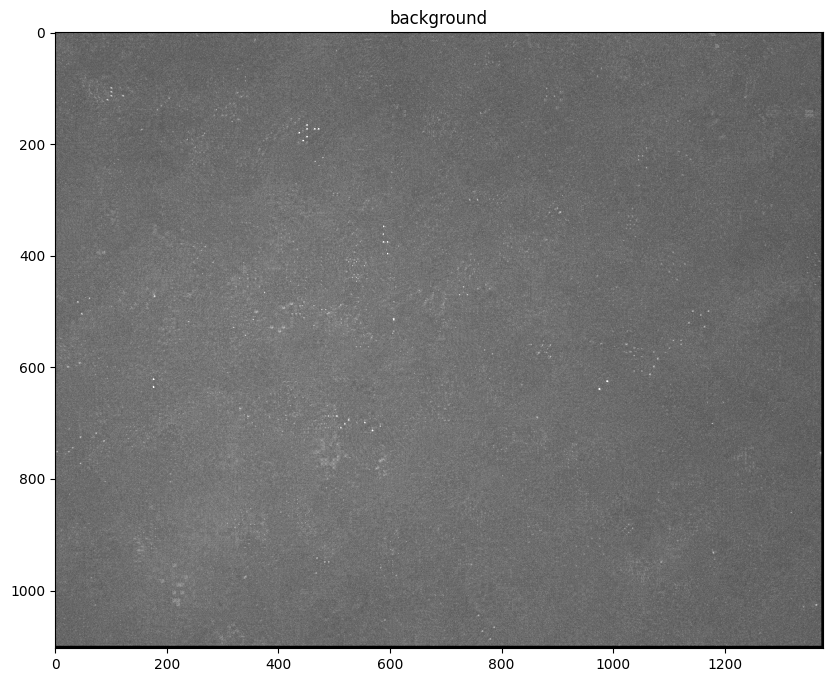

In [41]:
plt.figure(figsize=[10, 8])
plt.title("background")
plt.imshow(background, 'gray', vmin=0, vmax=60)

### Backup

In [ ]:
import pickle
import numpy as np
from PIL import Image
import skimage as ski
import sys, time
import geopandas as gpd
from matplotlib import pyplot as plt
from Image_properties import props

sys.path.insert(0, "/home/adriano/projeto_mestrado/modules")

from Funcoes_gerais import funcoes

import background_generation as backgen

root_dir = f"/home/adriano/projeto_mestrado/modules"

img_dir = f'{root_dir}/Imagens/vessel_data/images/'
lab_dir = f'{root_dir}/Imagens/vessel_data/labels_20x/'
pickle_dir = f'{root_dir}/Vessel_Models_pickle'
background_dir = f'{root_dir}/Background/Mapas_gerados_artificialmente'
tracados_dir = f'{root_dir}/Artificial_Lines/tracados_bezier'
#img_especifica = 'Experiment #1 (adults set #1)_20x_batch1 - Superficial layers@40-Image 3-20X'

array_pickles = funcoes.ler_diretorios(pickle_dir)
array_backgrounds = funcoes.ler_diretorios(background_dir)
array_tracados = funcoes.ler_diretorios(tracados_dir)


n_backgrounds = np.random.randint(0, len(array_backgrounds))
n_tracados = np.random.randint(0, len(array_tracados))
tracado = array_tracados[n_tracados]

array_medial_path = backgen.retorna_paths(f'{tracados_dir}/{tracado}')

#back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))
back_artif = np.array(Image.open(f'{background_dir}/{array_backgrounds[n_backgrounds]}'))

possui_mapas =  np.full(shape = back_artif.shape, fill_value=0)

vetor_informacoes = []
vetor_mapas_sem_artefatos = []
vetor_mapas_originais = []
vetor_vasos_sem_artefados = []
vetor_mask_map = []
vetor_mask_vaso = []
vetor_mapas_originais_norm = []
vetor_limiares1 = []
vetor_limiares2 = []

for i in range(len(array_medial_path)):
#for i in range(2):  
  n_random = np.random.randint(0, len(array_pickles))  
  
  path = (pickle_dir + f'/{array_pickles[n_random]}')
  print(f'{array_pickles[n_random]}')

  arquivo_pickle = pickle.load(open(path, 'rb')) 
  vessel_map = arquivo_pickle['vessel_model'].vessel_map 
  mapa_original = vessel_map.mapped_values
  
  imagem_binaria_original = vessel_map.mapped_mask_values 
  imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)
  
  imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais) 
  
  mapa_original_hist = backgen.histograma_matching(mapa_original,imagem_binaria_sem_artefatos,back_artif)
  
  rows, cols = mapa_original.shape  

  distancia = (rows/2) 
  
  limiar1 = backgen.encontrar_pixel_mais_frequente(mapa_original_hist)  
  
  limiar2 = backgen.encontrar_mediana_fundo_mapa(mapa_original_hist,imagem_binaria_sem_artefatos)  
  
  caminhos_transladados = backgen.retorna_caminhos_transladados(array_medial_path[i],0) # type: ignore 

  maior_valor = np.max(caminhos_transladados[0])
  
  mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original_hist,maior_valor) 
  
  vaso_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor) 
 
  dict = {
      "path": path,
      "arquivo_pickle": arquivo_pickle,
      "vessel_map": vessel_map,
      "mapa_original": mapa_original,
      "imagem_binaria_original": imagem_binaria_original,
      "imagem_binaria_sem_artefatos_laterais": imagem_binaria_sem_artefatos_laterais,  
      "imagem_binaria_sem_artefatos": imagem_binaria_sem_artefatos,    
      "mapa_original_hist":mapa_original_hist,    
      "caminhos_transladados": caminhos_transladados,
      "maior_valor": maior_valor,
      "mapa_expandido_original": mapa_expandido_original,
      "vaso_expandido_bin": vaso_expandido_bin,
      "rows": rows,
      "cols": cols,
      "distancia": distancia,
      "limiar1": limiar1,
      "limiar2": limiar2
    }
  vetor_informacoes.append(dict)

fundo_com_vasos = back_artif.copy()

for i in range(len(array_medial_path)): 

    caminhos_transladados = vetor_informacoes[i]['caminhos_transladados'] # type: ignore
    maior_valor = vetor_informacoes[i]['maior_valor'] # type: ignore
    distancia = vetor_informacoes[i]['distancia'] # type: ignore
    mapa_original = vetor_informacoes[i]['mapa_original'] # type: ignore    
    mapa_original_hist = vetor_informacoes[i]["mapa_original_hist"] 
    imagem_binaria_sem_artefatos = vetor_informacoes[i]['imagem_binaria_sem_artefatos'] # type: ignore
    mapa_expandido_original = vetor_informacoes[i]['mapa_expandido_original'] # type: ignore
    vaso_expandido_bin = vetor_informacoes[i]['vaso_expandido_bin'] # type: ignore     
    vessel_map = vetor_informacoes[i]['vessel_map'] # type: ignore
    limiar1 = vetor_informacoes[i]['limiar1'] # type: ignore 
    limiar2 = vetor_informacoes[i]['limiar2'] # type: ignore 
    vetor_limiares1.append(limiar1)
    vetor_limiares2.append(limiar2)
    
    linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_medial_path[i],distancia)  
    
    #Criação das linhas à direita, centro e à esquerda a partir do traçado originado pelas curvas de beizier
    dst_array_np = backgen.retorna_dst_array_np(linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho)
   
    
    #Execução do algoritmo que faz a transformação do mapa expandido
    img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.rotacionando_mapa_expandido(mapa_original_hist,dst_array_np,maior_tamanho)   
    
    #Máscara do mapa
    mask_map = backgen.criar_mascara_binaria_mapa(new_dst,img_out)
    vetor_mask_map.append(mask_map)
    
    #Máscara do vaso
    mask_vaso = backgen.criar_mascara_binaria_vaso(vessel_map,new_origin,array_medial_path[i],img_out)
    vetor_mask_vaso.append(mask_vaso)
    
    #Vaso binário rotacionado
    vaso_binario_rotacionado = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)   
    
    #Mapa sem artefatos
    mapa_sem_artefatos = backgen.retirar_artefatos(img_out,mask_map)  
    
    #Vaso binário expandido e rotacionado
    img_out_bin = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)
    
    #Vaso binário rotacionado sem artefatos
    vaso_sem_artefatos = backgen.retirar_artefatos(img_out_bin,mask_vaso)    
    vetor_vasos_sem_artefados.append(vaso_sem_artefatos)    
    
    #mapa_sem_artefatos = backgen.transf_map_dist(mapa_sem_artefatos_1,mask_map,vaso_sem_artefatos,back_artif)
    vetor_mapas_sem_artefatos.append(mapa_sem_artefatos)
    
    
    try:
      mapa_sem_artefatos = backgen.transf_map_dist(mapa_sem_artefatos,mask_map,vaso_sem_artefatos,back_artif)
    except:
      pass
    
    try:
      fundo_com_vasos = backgen.inserir_mapa(fundo_com_vasos,vaso_sem_artefatos,mapa_sem_artefatos,mask_map, limiar1, possui_mapas)
    except:
      pass




plt.figure(figsize=[10, 8])
plt.title("fundo_com_vasos")
plt.imshow(fundo_com_vasos, 'gray', vmin=0, vmax=60)
plt.plot()

img1 = Image.fromarray(fundo_com_vasos.astype(np.uint8))

img = img1.save("teste4.tiff")
    

    

### Inserindo os vasos

In [ ]:
  
plt.figure(figsize=[10, 8])
plt.title("mapa_original")
plt.imshow(mapa_original, 'gray', vmin=0, vmax=60)
plt.plot()

  
plt.figure(figsize=[10, 8])
plt.title("mapa_expandido_original")
plt.imshow(mapa_expandido, 'gray', vmin=0, vmax=60)
plt.plot()


### Plots dos mapas

In [ ]:

# plt.figure(figsize=[10, 8])
# plt.title("fundo com vaso")
# plt.imshow(img, 'gray', vmin=0, vmax=60)
# plt.plot()

plt.figure(figsize=[30, 30])
plt.title("mapa_sem_artefatos")
for i in range(len(vetor_mapas_sem_artefatos)):  
    plt.subplot(1,len(vetor_mapas_sem_artefatos),i+1)  
    plt.imshow(vetor_mapas_sem_artefatos[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[30, 30])
plt.title("Mapas normalizados")
for i in range(len(vetor_mapas_originais_norm)):  
    plt.subplot(1,len(vetor_mapas_originais_norm),i+1)  
    plt.imshow(vetor_mapas_originais_norm[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[20, 16])
for i in range(len(vetor_mapas_originais)):    
    plt.subplot(1,len(vetor_mapas_originais),i+1)    
    plt.imshow(vetor_mapas_originais[i], 'gray', vmin=0, vmax=60)

# plt.figure(figsize=[20, 16])
# plt.title("Mapas mergeados e normalizados")
# for i in range(len(vetor_mapas_originais_merge_norm_random)):  
#     plt.subplot(1,len(vetor_mapas_originais_merge_norm_random),i+1)  
#     plt.imshow(vetor_mapas_originais_merge_norm_random[i], 'gray', vmin=0, vmax=60)
    
# plt.figure(figsize=[20, 16])
# plt.title("vetor_mapa_original_hist")
# for i in range(len(vetor_img_map_hist)):  
#     plt.subplot(1,len(vetor_img_map_hist),i+1)  
#     plt.imshow(vetor_img_map_hist[i], 'gray', vmin=0, vmax=60)



### Plots dos traçados

In [ ]:
for i in range(len(array_medial_path)):    
    #caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(array_medial_path[i], 2) # type: ignore

    linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_medial_path[i],distancia)

    gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])
    gp4.plot(cmap="tab10")

### Exibe os backgrounds

In [ ]:
# for i in range(len(array_backgrounds)):
#    back_artif = np.array(Image.open(f'{background_dir}/{array_backgrounds[i]}'))
#    plt.figure(figsize=[10, 8])
#    plt.title(f'{array_backgrounds[i]}')
#    plt.imshow(back_artif, 'gray', vmin=0, vmax=60)
#    plt.plot()
  


In [ ]:
back = f'{background_dir}/{array_backgrounds[n_backgrounds]}'
back

print(problema)
plt.figure(figsize=[10, 8])
plt.title("fundo_com_vasos")
plt.imshow(fundo_com_vasos, 'gray', vmin=0, vmax=255)
plt.plot()

In [1]:
import background_generation as backgen
import numpy as np
import pickle
from pathlib import Path
from PIL import Image
import sys
from matplotlib import pyplot as plt

import background_generation as backgen
#windows
sys.path.insert(0, r"C:\Users\adria\Documents\Mestrado\texture_codes\modules")
root_dir = Path(r"C:\Users\adria\Documents\Mestrado\texture_codes\modules")

#linux
#sys.path.insert(0, "/home/adriano/projeto_mestrado/modules/")
#root_dir = f"/home/adriano/projeto_mestrado/modules"

from Utils import functions


def return_background(generate,dir_images,dir_labels,directory_backs,vector_backgrounds,img_back):
    if generate:
        while not img_back in vector_backgrounds:
            if img_back in dir_images and img_back in dir_labels:
                background = backgen.estimate_background(f'{dir_images}/{img_back}', f'{dir_labels}/{img_back}')
            else:
                n_background = np.random.randint(0, len(vector_backgrounds))
                img_back = vector_backgrounds[n_background]
                background = np.array(Image.open(f'{directory_backs}/{vector_backgrounds[n_background]}')) 
    else:
        n_background = np.random.randint(0, len(vector_backgrounds))
        img_back = vector_backgrounds[n_background]
        background = np.array(Image.open(f'{directory_backs}/{img_back}'))
    return background 

def returns_array_pickle(num_maps,array_maps_pickle):
    sorted_array_pickels = []
    for i in range(num_maps):
        n_pickle = np.random.randint(1, len(array_maps_pickle))    
        sorted_array_pickels.append(array_maps_pickle[n_pickle])
    return sorted_array_pickels

def compatible_map_with_backg(sorted_array_pickels, array_backrounds, directory_backs,dir_maps_pickle):
    n_background = np.random.randint(0, len(array_backrounds))
    img_back = array_backrounds[n_background]
    background = np.array(Image.open(f'{directory_backs}/{img_back}'))
    cont = 0
    for i in range(len(sorted_array_pickels)):
        path_map = (f"{dir_maps_pickle}/{sorted_array_pickels[i]}")
        map_pickle = pickle.load(open(path_map, 'rb'))           
        vessel_map = map_pickle['vessel_model'].vessel_map 
        original_map = vessel_map.mapped_values
        vessel_mask = vessel_map.mapped_mask_values
        normalized_original_map = backgen.normalize(background,original_map,vessel_mask,40)            
        if normalized_original_map is not None:
            cont += 1                  
    if cont == len(sorted_array_pickels):
        return img_back
    else:
        return None

def check_compatible(array_pickles,number_images,array_backrounds, directory_backs,dir_maps_pickle,dir_images,dir_labels):
    count_errors = 0
    vector_names = []
        
    for i in range(number_images):       
        name =  compatible_map_with_backg(array_pickles, array_backrounds, directory_backs, dir_maps_pickle)
        if name is not None:        
            vector_names.append(name)
        else:
            count_errors += 1       
    print(f"incompatible: {count_errors}")
    return vector_names


def generate_maps(params):
    array_maps_pickle = functions.read_directories(params['dir_maps_pickle'])
    array_images = functions.read_directories(params['dir_images'])
    array_labels = functions.read_directories(params['dir_labels'])
    array_backrounds = functions.read_directories(params['dir_backs'])
   

    number_maps = params['num_maps']
    dir_maps_pickle = params['dir_maps_pickle']
    directory_backs = params['dir_backs']
   
    directory_out = params['out_dir']
    num_images = params['num_images']
    min_number_vessels = params['min_number_vessels']
    max_number_vessels = params['max_number_vessels']    

    array_maps_pickle_sorted = returns_array_pickle(number_maps,array_maps_pickle)    

    #compatible_map_with_backg(array_maps_pickle_sorted, array_backrounds, directory_backs,dir_maps_pickle)

    vector_names_background = check_compatible(array_maps_pickle, num_images,array_backrounds,directory_backs,dir_maps_pickle)   

In [2]:
if __name__ == '__main__':

    #Aumentar o limiar para testar se fica compatível no máximo valor
    #Gerar as curvas de bezier dentro do algoritmo - tamanho setado pelo cliente - distancia entre o ponto 1 e ponto 2, numero de pontos, max_vd, 
    parameters = { 'dir_maps_pickle': f'{root_dir}/Vessel_models_pickle',
                'num_maps': 30, # number of maps to be inserted
                'num_images': 100, #number of images desired
                'dir_backs': f'{root_dir}/Background/Artificially_generated_maps', #background's directory
                'dir_images': f'{root_dir}/Images/vessel_data/images', # original images directory
                'dir_labels': f'{root_dir}/Images/vessel_data/labels_20x', # label directory
                'dir_traces': f'{root_dir}/Artificial_lines/bezier_traces', # directory of traces - Bezier curves
                'generate_back':False, #
                'out_dir': f'{root_dir}/Images/Background_with_vessels_tests', #output directory
                'min_number_vessels': 2, # minimum number of vessels
                'max_number_vessels': 5, # maximum number of vessels
                # Bezier Curves parameters
                'max_vd' : 500,
                'precision': 100,
                'number_cols': 1776,
                'number_rows': 1504,
                'number_points': 25,
            }    
    #generate_maps(parameters)

In [7]:
array_backrounds = functions.read_directories(parameters['dir_backs'])
directory_backs = parameters['dir_backs']

n_background = np.random.randint(0, len(array_backrounds))

img_back = array_backrounds[n_background] or None

if img_back is not None:
      background = np.array(Image.open(f'{directory_backs}/{img_back}'))
else:
      background = backgen.estimate_background()

In [9]:
img_back = array_backrounds[n_background]


In [10]:
img_back

'T-3 Weeks@Females@922 F@922-CTL-bottom-20X-02.tiff'